In [16]:
import pandas as pd
target = pd.read_csv('data/training_set_labels.csv')
data = pd.read_csv('data/training_set_features.csv')

drop_seasonal = ['respondent_id',
#                  'doctor_recc_seasonal', 
#                  'opinion_seas_vacc_effective', 
#                  'opinion_seas_risk', 
#                  'opinion_seas_sick_from_vacc', 
                 'seasonal_vaccine']

data = data.merge(target, on="respondent_id").drop(columns=drop_seasonal)

# drop_h1n1 = ['respondent_id',
#              'doctor_recc_h1n1', 
#              'opinion_h1n1_vacc_effective', 
#              'opinion_h1n1_risk ', 
#              'opinion_h1n1_sick_from_vacc', 
#              'h1n1_vaccine']

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn import svm

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [4]:
def grab_numeric(df):
    return df.select_dtypes(['float64', 'int64'])

GrabNumeric = FunctionTransformer(grab_numeric)

In [5]:
num_features = list(range(0, 17)) + [27, 28]
cat_features = list(range(17, 27)) + [29, 30]

In [6]:
numeric_transformer = Pipeline(
    steps=[('grab_num', GrabNumeric), 
           ('num_impute', SimpleImputer(strategy='median', add_indicator=True)), 
           ('scaler', StandardScaler())])

categorical_transformer = Pipeline(
    steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
           ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)], remainder='passthrough')

In [7]:
models = {'Baseline':
              {'regressor': LogisticRegression(random_state=20220124, max_iter=1000),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran' : None
              },
          'DecisionTree':
              {'regressor': DecisionTreeClassifier(random_state=20211122),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },
          'RandomForest':
              {'regressor': RandomForestClassifier(random_state=10151997),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },
          'GradientBoost':
              {'regressor': GradientBoostingClassifier(random_state=20220125),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },  
#           'AdaBoost':
#               {'regressor': AdaBoostClassifier(random_state=20220126),
#                'preprocessor': preprocessor,
#                'output': None,
#                'fit_regressor': None,
#                'time_ran': None
#               },  
#           'SVM':
#               {'regressor': svm.SVC(random_state=20220127, probability=True),
#                'preprocessor': preprocessor,
#                'output': None,
#                'fit_regressor': None,
#                'time_ran': None
#               },  
         }

In [8]:
def data_split(data, target):
    X = data.drop(columns=target)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10151997)
    return X_train, X_test, y_train, y_test

In [9]:
def run_models(models, data, target):
    """
    Takes in dict of models to run, df of dataset, string name of target
    Prints every model in dict, its accuracy, precision, auc scores, and time it took to ran 
    """
    X_train, X_test, y_train, y_test = data_split(data, target)
    for name, model in models.items():
        print(name, 'Model:')
        X_train_processed = model['preprocessor'].fit_transform(X_train)
        X_test_processed = model['preprocessor'].transform(X_test)
        model['fit_regressor'] = model['regressor'].fit(X_train_processed, y_train)
        model['output'] = [model['fit_regressor'].score(X_test_processed, y_test), 
                           precision_score(y_test, model['regressor'].predict(X_test_processed)), 
                           roc_auc_score(y_test, model['regressor'].predict_proba(X_test_processed)[:,1])]
        model['time_ran'] = time.asctime()
        print(model, '\n')

In [10]:
#run_models(models, data, 'h1n1_vaccine')

In [11]:
def run_gridsearch(models, params, data, target):
    X_train, X_test, y_train, y_test = data_split(data, target)
    for model in models:
        if model in params.keys():
            print(model, 'Grid Search:')
            pipe = Pipeline(steps=[('col_transformer', models[model]['preprocessor']), 
                             ('regressor', models[model]['regressor'])])
            grid = params[model]
            gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='precision', cv=5)
            gridsearch.fit(X_train, y_train)
            print(f'Cross validation mean: {gridsearch.cv_results_["mean_test_score"]}')
            print(f'Test precision: {gridsearch.best_score_ :.2%}')
            print(f'Optimal prameters: {gridsearch.best_params_}')

***

In [15]:
# import pandas as pd
# target = pd.read_csv('data/training_set_labels.csv')
# data = pd.read_csv('data/training_set_features.csv')

# drop_seasonal = ['respondent_id',
#                  'seasonal_vaccine']

# tree_df = data.merge(target, on="respondent_id").drop(columns=drop_seasonal)
# data_split(tree_df, 'h1n1_vaccine')

In [14]:
# pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeClassifier())])
# grid = {'regressor__criterion': ['gini', 'entropy'],
#         'regressor__splitter': ['best', 'random'],
#         'regressor__max_depth': [None, 2, 5, 10, 15],
#         'regressor__min_samples_split': [5, 10, 20],
#         'regressor__min_samples_leaf': [2, 5, 15, 20],
#         'regressor__class_weight': ['balanced', None]
#        }
# gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='precision', cv=5)
# gridsearch.fit(X_train, y_train)
# print(f'Cross validation mean: {gridsearch.cv_results_["mean_test_score"]}')
# print(f'Test precision: {gridsearch.best_score_ :.2%}')
# print(f'Optimal prameters: {gridsearch.best_params_}')

In [ ]:
params_dt = {'DecisionTree': [{'regressor__criterion': ['gini', 'entropy'],
                            #'regressor__splitter': ['best', 'random'],
                            'regressor__max_depth': [None, 2, 5, 10, 15],
                            #'regressor__min_samples_split': [5, 10, 20],
                            #'regressor__min_samples_leaf': [2, 5, 15, 20],
                            #'regressor__class_weight': ['balanced', None]
                           }]}

In [ ]:
# run_gridsearch(models, params_dt, data, 'h1n1_vaccine')

In [ ]:
# params_rf = {'RandomForest': [{
#     'regressor__n_estimators':[10, 30, 100],
#     'regressor__criterion':['gini', 'entropy'],
#     'regressor__max_depth':[None, 2, 6, 10],
#     'regressor__min_samples_split':[5, 10],
#     'regressor__min_samples_leaf':[3, 6]}]}

In [ ]:
# run_gridsearch(models, params_rf, data, 'h1n1_vaccine')

***

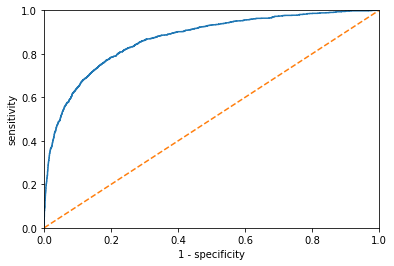

In [22]:
X1 = data.drop(columns='h1n1_vaccine').fillna('Unknown')
X1 = pd.get_dummies(X1, drop_first=True)
y1 = data['h1n1_vaccine']
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.25, random_state=10151997)

model = LogisticRegression(max_iter=1000) 
model.fit(X_train, y_train) 
y_pred_proba = model.predict_proba(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1]) 

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.xlabel('1 - specificity') 
plt.ylabel('sensitivity') 
plt.show()

(0.0, 1.0)

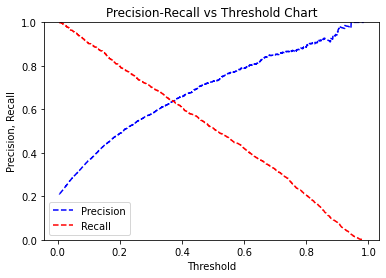

In [27]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y=model.predict(X_test) 

probs_y=model.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first 
  #column of 
  # array) vs 1 (2nd column in array)

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [37]:
X2 = data.drop(columns='h1n1_vaccine').fillna('Unknown')
X2 = pd.get_dummies(X1, drop_first=True)
y2 = data['h1n1_vaccine']
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=.25, random_state=10151997)

clf = LogisticRegression(class_weight="balanced", max_iter=1000)
clf.fit(X_train, y_train)
THRESHOLD = 0.75
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.857571
recall,0.561644
precision,0.694296
roc_auc_score,0.748402


***

In [ ]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [ ]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

In [ ]:
X_train_clean = X_train.select_dtypes('float64').dropna()
y_train_clean = y_train[X_train_clean.index]

In [ ]:
X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

In [ ]:
X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

In [ ]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', SMOTE(random_state=42)),
                            ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
imb_pipe.fit(X_train, y_train)

In [ ]:
imb_pipe.score(X_train, y_train)

In [ ]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [ ]:
params = {'RandomForest': {
    'n__estimators':[10, 30, 100],
    'criterion':['gini', 'entropy'],
    'max__depth':[None, 2, 6, 10],
    'min__samples_split':[5, 10],
    'min__samples_leaf':[3, 6]}}

***